In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection

In [108]:
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch import nn

In [109]:
# Load the data
df_test = pd.read_csv('prepped_data/test_data.csv')
df_train_val = pd.read_csv('prepped_data/train_data.csv')

#split the training data into training and validation
df_val = df_train_val[df_train_val['date'] > '2022-03-01']
df_train = df_train_val[df_train_val['date'] <= '2022-03-01']

In [110]:
# #Split train into X and Y
Xtrain = df_train.iloc[:, 8:].copy()
ytrain = df_train["PM25_ugm3"].copy()

# #Split test into X and Y
Xtest = df_test.iloc[:, 8:].copy()
ytest = df_test["PM25_ugm3"].copy()

# #Split val into X and Y
Xval = df_val.iloc[:, 8:].copy()
yval = df_val["PM25_ugm3"].copy()

# #Split train_val into X and Y
Xtrain_val = df_train_val.iloc[:, 8:].copy()
ytrain_val = df_train_val["PM25_ugm3"].copy()

In [111]:
#take the lof of the target variable
ytrain = np.log(ytrain)
ytest = np.log(ytest)
yval = np.log(yval)
ytrain_val = np.log(ytrain_val)

In [112]:
#running a simple imputer and scaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

#imputer = SimpleImputer(strategy = "mean")
imputer = SimpleImputer()
Xtrain = imputer.fit_transform(Xtrain)
Xtest = imputer.transform(Xtest)
Xval = imputer.transform(Xval)
Xtrain_val = imputer.transform(Xtrain_val)

# Convert arrays back to DataFrame for easier manipulation
Xtrain = pd.DataFrame(Xtrain, columns=df_train.columns[8:])
Xtest = pd.DataFrame(Xtest, columns=df_test.columns[8:])
Xval = pd.DataFrame(Xval, columns=df_val.columns[8:])
Xtrain_val = pd.DataFrame(Xtrain_val, columns=df_train_val.columns[8:])

In [113]:
from sklearn.preprocessing import OneHotEncoder

# Assuming you know the names of the categorical columns
categorical_columns = ['SiteID', 'day_of_week']  # List of categorical column names

# Initialize the OneHotEncoder
encoder = OneHotEncoder()

# Fit the encoder on the training data
encoder.fit(Xtrain[categorical_columns])

# Transform both training and test data
Xtrain_encoded = encoder.transform(Xtrain[categorical_columns])
Xtest_encoded = encoder.transform(Xtest[categorical_columns])
Xval_encoded = encoder.transform(Xval[categorical_columns])
Xtrain_val_encoded = encoder.transform(Xtrain_val[categorical_columns])

# Convert the encoded data to a DataFrame
Xtrain_encoded = pd.DataFrame(Xtrain_encoded.toarray(), columns=encoder.get_feature_names_out(categorical_columns))
Xtest_encoded = pd.DataFrame(Xtest_encoded.toarray(), columns=encoder.get_feature_names_out(categorical_columns))
Xval_encoded = pd.DataFrame(Xval_encoded.toarray(), columns=encoder.get_feature_names_out(categorical_columns))
Xtrain_val_encoded = pd.DataFrame(Xtrain_val_encoded.toarray(), columns=encoder.get_feature_names_out(categorical_columns))

# Drop the original categorical columns from the training and test data
Xtrain = Xtrain.drop(columns=categorical_columns)
Xtest = Xtest.drop(columns=categorical_columns)
Xval = Xval.drop(columns=categorical_columns)
Xtrain_val = Xtrain_val.drop(columns=categorical_columns)

# Concatenate the one-hot encoded columns to the training and test data
Xtrain = pd.concat([Xtrain, Xtrain_encoded], axis=1)
Xtest = pd.concat([Xtest, Xtest_encoded], axis=1)
Xval = pd.concat([Xval, Xval_encoded], axis=1)
Xtrain_val = pd.concat([Xtrain_val, Xtrain_val_encoded], axis=1)

Scaling

In [114]:
# Standardize the data
scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)
Xval_scaled = scaler.transform(Xval)
Xtrain_val_scaled = scaler.transform(Xtrain_val)

#standardize the target variable
#scaler = StandardScaler()
#ytrain_scaled = scaler.fit_transform(ytrain.values.reshape(-1, 1)).flatten()
#ytest_scaled = scaler.transform(ytest.values.reshape(-1, 1)).flatten()
#yval_scaled = scaler.transform(yval.values.reshape(-1, 1)).flatten()
#ytrain_val_scaled = scaler.transform(ytrain_val.values.reshape(-1, 1)).flatten()

# Convert arrays back to DataFrame for easier manipulation
Xtrain = pd.DataFrame(Xtrain_scaled, columns=Xtrain.columns)
Xtest = pd.DataFrame(Xtest_scaled, columns=Xtest.columns)
Xval = pd.DataFrame(Xval_scaled, columns=Xval.columns)
Xtrain_val = pd.DataFrame(Xtrain_val_scaled, columns=Xtrain_val.columns)

# Convert arrays back to DataFrame for easier manipulation
#ytrain = pd.DataFrame(ytrain_scaled, columns=["PM25_ugm3"])
#ytest = pd.DataFrame(ytest_scaled, columns=["PM25_ugm3"])
#yval = pd.DataFrame(yval_scaled, columns=["PM25_ugm3"])
#ytrain_val = pd.DataFrame(ytrain_val_scaled, columns=["PM25_ugm3"])

In [115]:
train_bs = 64
val_bs = 64
test_bs = 64
train_val_bs = 64
#Batchsize is a Hyperparameter, it is a tradeoff between speed and accuracy. We use 32 here to start as this was the value from the tutorials.

# Create tensor datasets
train_dataset = TensorDataset(torch.tensor(Xtrain.values).float(), torch.tensor(ytrain.values).unsqueeze(1).float())
val_dataset = TensorDataset(torch.tensor(Xval.values).float(), torch.tensor(yval.values).unsqueeze(1).float())
test_dataset = TensorDataset(torch.tensor(Xtest.values).float(), torch.tensor(ytest.values).unsqueeze(1).float())
train_val_dataset = TensorDataset(torch.tensor(Xtrain_val.values).float(), torch.tensor(ytrain_val.values).unsqueeze(1).float())

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=train_bs, shuffle=False, drop_last=True) #dataset
val_dataloader = DataLoader(val_dataset, batch_size=val_bs, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_bs, shuffle=False, drop_last=True)
train_val_dataloader = DataLoader(train_val_dataset, batch_size=train_val_bs, shuffle=False, drop_last=True)

Start of Model fitting

In [32]:
def train_loop(dataloader, model, loss_fn, optimiser):
    avg_loss = 0 # to store running loss
    model.train() # Set model in training mode
    for batch_idx, (X, y) in enumerate(dataloader):
        pred = model(X) # make prediction on current batch
        loss = loss_fn(pred,y) # calculate loss
        loss.backward() # calculates gradients
        optimiser.step() # update weights
        optimiser.zero_grad() # set gradients to zero for next batch
        avg_loss += loss.item() # add loss to running loss
    print(f'Average training Loss: {avg_loss/len(dataloader):.5f}')
    train_loss = avg_loss/len(dataloader)
    return train_loss

In [33]:
def val_loop(dataloader, model, loss_fn):
    loss = 0
    model.eval()
    bs = dataloader.batch_size
    for batch_idx, (X, y) in enumerate(dataloader):
        pred = model(X) # make prediction on current batch
        loss += loss_fn(pred,y).item() # calculate loss

    loss /= len(dataloader)
    print(f'Avg val loss: {loss:.5f} \n')

    return loss

In [34]:
def nonlinearity_constructor(name):
    if (name == "relu"):
        return nn.ReLU()
    if (name == "sigmoid"):
        return nn.Sigmoid()
    if (name == "leakyrelu"):
        return nn.LeakyReLU()
    raise ValueError("Unknown nonlinearity!")

Model 1:

Epoch 1
Average training Loss: 0.44504
Avg val loss: 0.46960 

Epoch 2
Average training Loss: 0.46634
Avg val loss: 4.64758 

Epoch 3
Average training Loss: 1.30778
Avg val loss: 0.23994 

Epoch 4
Average training Loss: 0.61949
Avg val loss: 0.36431 

Epoch 5
Average training Loss: 0.52441
Avg val loss: 0.22547 

Epoch 6
Average training Loss: 2.56174
Avg val loss: 1.12445 

Epoch 7
Average training Loss: 0.34221
Avg val loss: 0.20807 

Epoch 8
Average training Loss: 0.25530
Avg val loss: 0.24900 

Epoch 9
Average training Loss: 1.04511
Avg val loss: 0.49551 

Epoch 10
Average training Loss: 0.28341
Avg val loss: 1.42399 

Epoch 11
Average training Loss: 0.66789
Avg val loss: 0.37707 

Epoch 12
Average training Loss: 0.40336
Avg val loss: 0.73667 

Epoch 13
Average training Loss: 0.67394
Avg val loss: 0.33917 

Epoch 14
Average training Loss: 0.53677
Avg val loss: 0.26218 

Epoch 15
Average training Loss: 0.71724
Avg val loss: 0.25071 

Epoch 16
Average training Loss: 1.73299
Avg val l

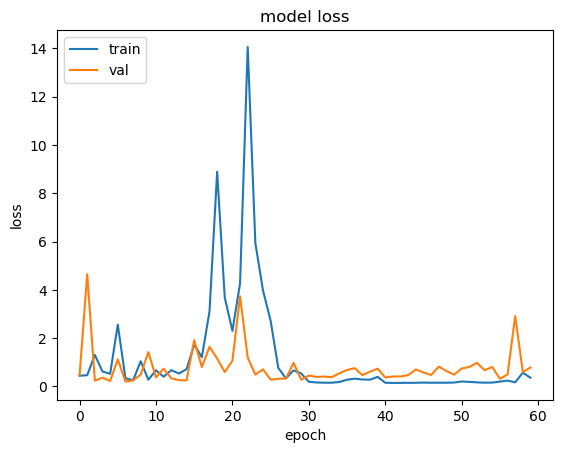

In [35]:
class Network1(nn.Module):
    def __init__(self,hid_layer=[100],nonlinearity = 'relu'):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hid_layer[0]),
            nonlinearity_constructor(nonlinearity),
            nn.Linear(hid_layer[0], 1)
        )
    def forward(self,x):
        return self.net(x)

input_dim = Xtrain.shape[1]
model = Network1(nonlinearity='leakyrelu')

learning_rate = 0.001
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)

train_loss_nn1 = []
val_loss_nn1 = []
epochs = 60
for epoch in range(epochs):
    print(f'Epoch {epoch+1}')
    train_loss_nn1.append(train_loop(train_dataloader, model, loss_fn, optimiser))
    val_loss_nn1.append(val_loop(val_dataloader, model, loss_fn))


#plot the training and validation loss
plt.plot(train_loss_nn1)
plt.plot(val_loss_nn1)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Model 2: 

Epoch 1
Average training Loss: 0.41093
Avg val loss: 0.29487 

Epoch 2
Average training Loss: 0.24094
Avg val loss: 0.38648 

Epoch 3
Average training Loss: 0.21363
Avg val loss: 0.26450 

Epoch 4
Average training Loss: 0.19245
Avg val loss: 0.25633 

Epoch 5
Average training Loss: 0.17884
Avg val loss: 0.24975 

Epoch 6
Average training Loss: 0.16421
Avg val loss: 0.27167 

Epoch 7
Average training Loss: 0.14761
Avg val loss: 0.24603 

Epoch 8
Average training Loss: 0.13641
Avg val loss: 0.25856 

Epoch 9
Average training Loss: 0.12969
Avg val loss: 0.30988 

Epoch 10
Average training Loss: 0.12128
Avg val loss: 0.36682 

Epoch 11
Average training Loss: 0.11585
Avg val loss: 0.29456 

Epoch 12
Average training Loss: 0.10958
Avg val loss: 0.53574 

Epoch 13
Average training Loss: 0.10217
Avg val loss: 0.28407 

Epoch 14
Average training Loss: 0.09752
Avg val loss: 0.39748 

Epoch 15
Average training Loss: 0.09327
Avg val loss: 0.36213 

Epoch 16
Average training Loss: 0.08751
Avg val l

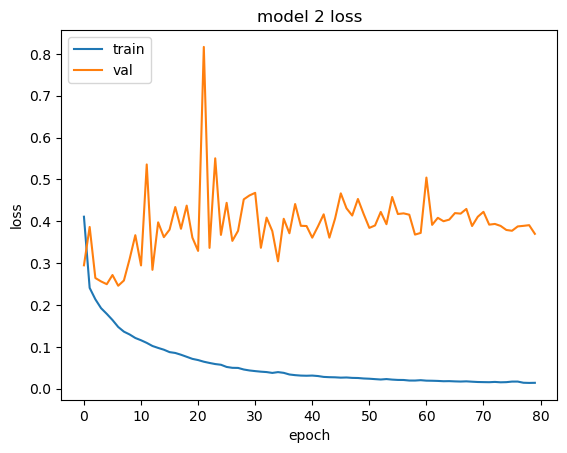

In [45]:
class Network2(nn.Module):
    def __init__(self,hid_layer=[100,100,100],nonlinearity = 'relu'): #Start with a default of 10, can change this in the call
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hid_layer[0]),
            nonlinearity_constructor(nonlinearity),
            nn.Linear(hid_layer[0], hid_layer[1]),
            nonlinearity_constructor(nonlinearity),
            nn.Linear(hid_layer[1], hid_layer[2]),
            nonlinearity_constructor(nonlinearity),
            nn.Linear(hid_layer[2], 1)
        )
    def forward(self,x):
        return self.net(x)

input_dim = Xtrain.shape[1]
model2 = Network2(nonlinearity='leakyrelu')

learning_rate = 0.001
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model2.parameters(), lr=learning_rate, weight_decay=1e-6)

train_loss_nn2 = []
val_loss_nn2 = []
epochs = 80
for epoch in range(epochs):
    print(f'Epoch {epoch+1}')
    train_loss_nn2.append(train_loop(train_dataloader, model2, loss_fn, optimiser))
    val_loss_nn2.append(val_loop(val_dataloader, model2, loss_fn))


#plot the training and validation loss
plt.plot(train_loss_nn2)
plt.plot(val_loss_nn2)
plt.title('model 2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


For this second model we see this divergence has imporoved, but remains problematic. 

Epoch 1


i:\Anaconda\envs\dsa2\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average training Loss: 0.87732
Avg val loss: 0.49081 

Epoch 2
Average training Loss: 0.84805
Avg val loss: 0.47752 

Epoch 3
Average training Loss: 0.84305
Avg val loss: 0.47736 

Epoch 4
Average training Loss: 0.83714
Avg val loss: 0.49319 

Epoch 5
Average training Loss: 0.84299
Avg val loss: 0.61917 

Epoch 6
Average training Loss: 0.83969
Avg val loss: 0.61808 

Epoch 7
Average training Loss: 0.83816
Avg val loss: 0.58944 

Epoch 8
Average training Loss: 0.83514
Avg val loss: 0.56589 

Epoch 9
Average training Loss: 0.83299
Avg val loss: 0.60577 

Epoch 10
Average training Loss: 0.83281
Avg val loss: 0.60497 

Epoch 11
Average training Loss: 0.82572
Avg val loss: 0.58878 

Epoch 12
Average training Loss: 0.82375
Avg val loss: 0.65214 

Epoch 13
Average training Loss: 0.81931
Avg val loss: 0.57564 

Epoch 14
Average training Loss: 0.82204
Avg val loss: 0.56569 

Epoch 15
Average training Loss: 0.81902
Avg val loss: 0.57742 

Epoch 16
Average training Loss: 0.81896
Avg val loss: 0.6

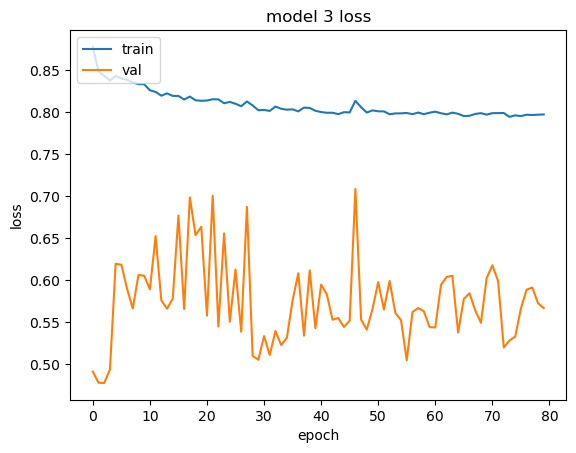

In [104]:
#With 3 layers and dropout
class Network3(nn.Module):
    def __init__(self,hid_layer=[100,100,100],nonlinearity = 'relu',dropout=0.5): #Start with a default of 10, can change this in the call
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hid_layer[0]),
            nonlinearity_constructor(nonlinearity),
            nn.Dropout(dropout),
            nn.Linear(hid_layer[0], hid_layer[1]),
            nonlinearity_constructor(nonlinearity),
            nn.Dropout(dropout),
            nn.Linear(hid_layer[1], hid_layer[2]),
            nonlinearity_constructor(nonlinearity),
            nn.Dropout(dropout),
            nn.Linear(hid_layer[2], 1)
        )
    def forward(self,x):
        return self.net(x)
    
input_dim = Xtrain.shape[1]
model3 = Network3(nonlinearity='leakyrelu')

learning_rate = 0.001
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model3.parameters(), lr=learning_rate, weight_decay=1e-4)

train_loss_nn3 = []
val_loss_nn3 = []
epochs = 80

for epoch in range(epochs):
    print(f'Epoch {epoch+1}')
    train_loss_nn3.append(train_loop(train_dataloader, model3, loss_fn, optimiser))
    val_loss_nn3.append(val_loop(val_dataloader, model3, loss_fn))


#plot the training and validation loss, cut off loss at 100
plt.plot(train_loss_nn3)
plt.plot(val_loss_nn3)
plt.title('model 3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


Epoch 1
Average training Loss: 0.67218
Epoch 2
Average training Loss: 0.40491
Epoch 3
Average training Loss: 0.34030
Epoch 4
Average training Loss: 0.32031
Epoch 5
Average training Loss: 0.29966
Epoch 6
Average training Loss: 0.27762
Epoch 7
Average training Loss: 0.26769
Epoch 8
Average training Loss: 0.25986
Epoch 9
Average training Loss: 0.24731
Epoch 10
Average training Loss: 0.24792
Epoch 11
Average training Loss: 0.23755
Epoch 12
Average training Loss: 0.23537
Epoch 13
Average training Loss: 0.23487
Epoch 14
Average training Loss: 0.23189
Epoch 15
Average training Loss: 0.22872
Epoch 16
Average training Loss: 0.22339
Epoch 17
Average training Loss: 0.21873
Epoch 18
Average training Loss: 0.21420
Epoch 19
Average training Loss: 0.21433
Epoch 20
Average training Loss: 0.21434
Epoch 21
Average training Loss: 0.21191
Epoch 22
Average training Loss: 0.20770
Epoch 23
Average training Loss: 0.20750
Epoch 24
Average training Loss: 0.20229
Epoch 25
Average training Loss: 0.19969
Epoch 26


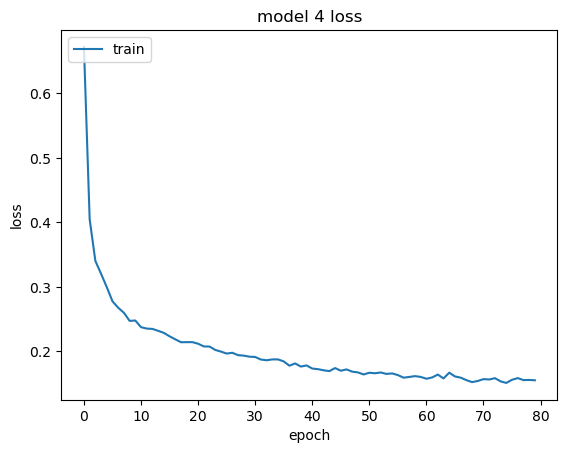

In [117]:
#make predictions on the test data
model4 = Network3(nonlinearity='leakyrelu')

learning_rate = 0.001
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model4.parameters(), lr=learning_rate, weight_decay=1e-4)

train_loss_nn4 = []
val_loss_nn4 = []
epochs = 80

for epoch in range(epochs):
    print(f'Epoch {epoch+1}')
    train_loss_nn4.append(train_loop(train_val_dataloader, model4, loss_fn, optimiser))

#plot the training and validation loss
plt.plot(train_loss_nn4)
plt.title('model 4 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()


Mean Squared Error: 0.25230


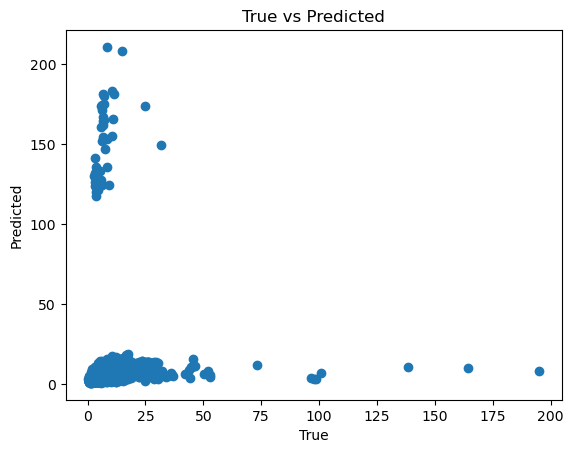

Mean Squared Error: 134.88338


In [119]:
#make predictions on the test data
model4.eval()
y_pred = []
y_true = []

for X, y in test_dataloader:
    y_pred.append(model4(X).detach().numpy())

y_pred = np.concatenate(y_pred).flatten()

#convert the true values from the dataloader into a numpy array
for X, y in test_dataloader:
    y_true.append(y.numpy())

y_true = np.concatenate(y_true).flatten()

mse = mean_squared_error(y_true, y_pred)
print(f'Mean Squared Error: {mse:.5f}')

#take the exponential of the predictions
y_pred = np.exp(y_pred)
y_true = np.exp(y_true)

#undo the scaling
#y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
#y_true = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()

#plot the predictions
plt.scatter(x= y_true, y = y_pred)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('True vs Predicted')
plt.show()

#calculate the mean squared error
from sklearn.metrics import mean_squared_error



mse = mean_squared_error(y_true, y_pred)
print(f'Mean Squared Error: {mse:.5f}')

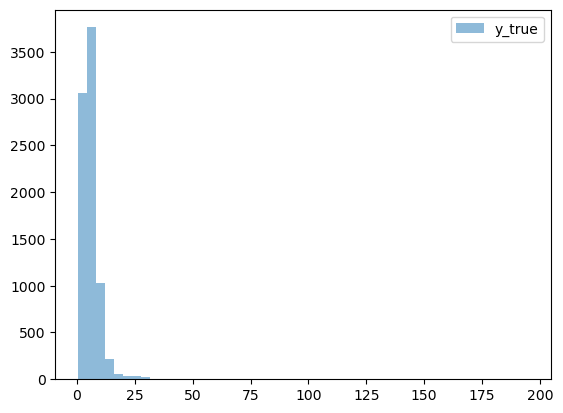

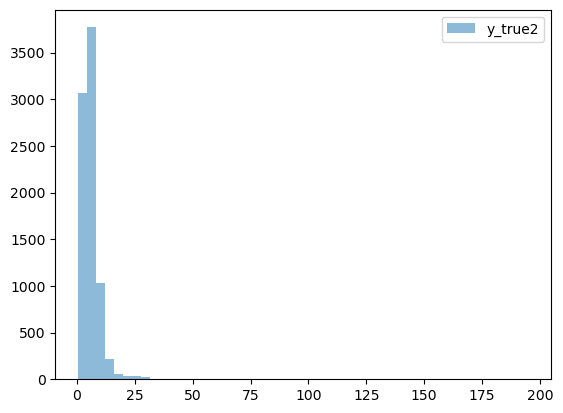

In [82]:
y_true2 = df_test["PM25_ugm3"].copy()

#compare the distributions of the log of y_true and y_true2
plt.hist(y_true, bins=50, alpha=0.5, label='y_true')
plt.legend(loc='upper right')
plt.show()

plt.hist(y_true2, bins=50, alpha=0.5, label='y_true2')
plt.legend(loc='upper right')
plt.show()


In [28]:
#Resnet model with dropout and 3 layers
class ResidualBlock(nn.Module):
    def __init__(self, in_features, dropout=0.5):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(in_features, in_features),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return x + self.block(x)

class ResNet(nn.Module):
    def __init__(self, in_features, num_residuals, dropout=0.5):
        super(ResNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, 100),
            nn.ReLU(),
            *[ResidualBlock(100, dropout) for _ in range(num_residuals)],
            nn.Linear(100, 1)
        )

    def forward(self, x):
        return self.model(x)

model5 = ResNet(input_dim, 10)

learning_rate = 0.001
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)


train_loss_nn5 = []
val_loss_nn5 = []
epochs = 200

for epoch in range(epochs):
    print(f'Epoch {epoch+1}')
    train_loss_nn5.append(train_loop(train_dataloader, model5, loss_fn, optimiser))
    val_loss_nn5.append(val_loop(val_dataloader, model5, loss_fn))

#plot the training and validation loss
plt.plot(train_loss_nn5)
plt.plot(val_loss_nn5)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()






Epoch 1
Average training Loss: 167.05767
Avg val loss: 184.69079 

Epoch 2
Average training Loss: 166.98357
Avg val loss: 184.69079 

Epoch 3
Average training Loss: 166.96847
Avg val loss: 184.69079 

Epoch 4


KeyboardInterrupt: 